<a href="https://colab.research.google.com/github/hublun/Tensor_Creek/blob/master/Golf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow.compat.v2 as tf

import tensorflow_probability as tfp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from time import time
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from functools import partial

import arviz as az  #we'll get to that

In [0]:
sns.set_palette("muted")
np.random.seed(1324)
dtype=tf.float32
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (9, 6),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
plt.rcParams.update(params)
%config InlineBackend.figure_format = 'retina'

In [0]:
sample_stats_name = ['log_likelihood','tree_size','diverging','energy','mean_tree_accept']

def tfp_trace_to_arviz(
    tfp_trace,
    var_names=None, 
    sample_stats_name=sample_stats_name):
    
    samps, trace = tfp_trace
    if var_names is None:
        var_names = ["var " + str(x) for x in range(len(samps))]
        
    sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, trace)}
    posterior = {name : tf.transpose(samp, [1, 0, 2]).numpy() for name, samp in zip(var_names, samps)}
    return az.from_dict(posterior=posterior, sample_stats=sample_stats)

In [0]:
def trace_fn(_, pkr):  
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
    )

In [0]:
n_chains = 10

def run_nuts_template(
    trace_fn,
    target_log_prob_fn,
    inits,
    bijectors_list=None, 
    num_steps=500,
    num_burnin=500,
    n_chains=n_chains):
    
    step_size = np.random.rand(n_chains, 1)*.5 + 1.
    
    if not isinstance(inits, list):
        inits = [inits]
        
    if bijectors_list is None:
        bijectors_list = [tfb.Identity()]*len(inits)

    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn,
                step_size=[step_size]*len(inits)
            ),
            bijector=bijectors_list
        ),
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*num_burnin),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
              inner_results=pkr.inner_results._replace(step_size=new_step_size)
          ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )
    
    res = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=num_burnin,
        current_state=inits,
        kernel=kernel,
        trace_fn=trace_fn
    )
    return res

In [0]:
run_nuts = partial(run_nuts_template, trace_fn)

run_nuts_opt = tf.function(run_nuts)
run_nuts_defun = tf.function(run_nuts, autograph=False)

In [0]:
run_nuts_defun_xla = tf.function(run_nuts, autograph=False, experimental_compile=True)

In [0]:
data = np.array([[2,1443,1346],
[3,694,577],
[4,455,337],
[5,353,208],
[6,272,149],
[7,256,136],
[8,240,111],
[9,217,69],
[10,200,67],
[11,237,75],
[12,202,52],
[13,192,46],
[14,174,54],
[15,167,28],
[16,201,27],
[17,195,31],
[18,191,33],
[19,147,20],
[20,152,24]])

new_data = np.array([[0.28, 45198, 45183],
[0.97, 183020, 182899],
[1.93, 169503, 168594],
[2.92, 113094, 108953],
[3.93, 73855, 64740],
[4.94, 53659, 41106],
[5.94, 42991, 28205],
[6.95, 37050, 21334],
[7.95, 33275, 16615],
[8.95, 30836, 13503],
[9.95, 28637, 11060],
[10.95, 26239, 9032],
[11.95, 24636, 7687],
[12.95, 22876, 6432],
[14.43, 41267, 9813],
[16.43, 35712, 7196],
[18.44, 31573, 5290],
[20.44, 28280, 4086],
[21.95, 13238, 1642],
[24.39, 46570, 4767],
[28.40, 38422, 2980],
[32.39, 31641, 1996],
[36.39, 25604, 1327],
[40.37, 20366, 834],
[44.38, 15977, 559],
[48.37, 11770, 311],
[52.36, 8708, 231],
[57.25, 8878, 204],
[63.23, 5492, 103],
[69.18, 3087, 35],
[75.19, 1742, 24]])

df = pd.DataFrame(data, columns = ['x','n','y'])
new_df = pd.DataFrame(new_data, columns = ['x','n','y'])

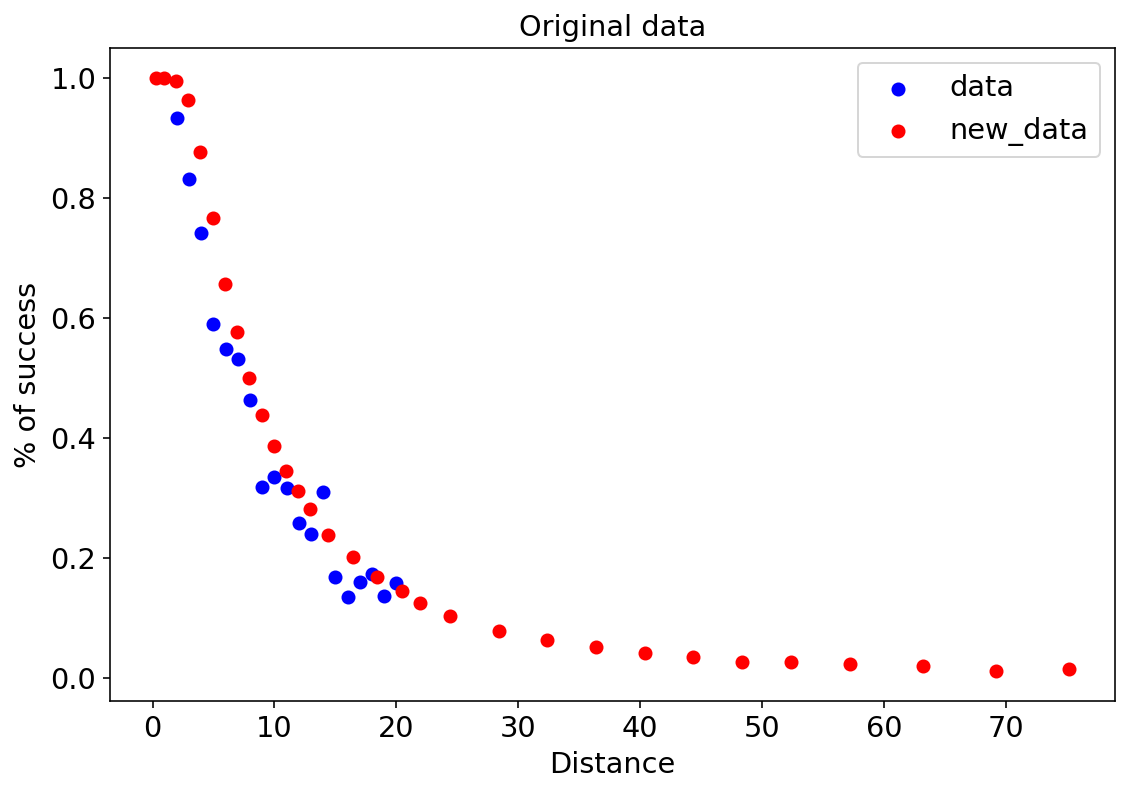

In [0]:
plt.scatter(df['x'],df['y']/df['n'],c='b',label='data')
plt.scatter(new_df['x'],new_df['y']/new_df['n'],c='r',label='new_data')
plt.legend()
plt.xlabel("Distance")
plt.ylabel("% of success")
plt.title("Original data");

In [0]:
root = tfd.JointDistributionCoroutine.Root

def golf_logistics():
    a = yield root(tfd.Sample(tfd.Normal(0, 1e6),1))
    b = yield root(tfd.Sample(tfd.Normal(0, 1e6),1))
    y = yield tfd.Independent(
        tfd.Binomial(
            total_count=tf.cast(new_df['n'], dtype),
            logits = a*tf.cast(new_df['x'], dtype)*b
        )
    )

golf_logistic_jd = tfd.JointDistributionCoroutine(golf_logistics)

In [0]:
golf_logistic_log_prob = lambda *args: golf_logistic_jd.log_prob(args + (tf.cast(new_df['y'], dtype),))

In [0]:
%%time
#res = run_nuts(golf_logistic_log_prob, [tf.ones((n_chains, 1)), tf.ones((n_chains, 1))])
#res = run_nuts_opt(golf_logistic_log_prob, [tf.ones((n_chains,1)), tf.ones((n_chains,1))])
#res = run_nuts_defun(golf_logistic_log_prob, [tf.ones((n_chains,1)), tf.ones((n_chains,1))])
res = run_nuts_defun_xla(golf_logistic_log_prob, [tf.ones((n_chains,1)), tf.ones((n_chains,1))])

CPU times: user 2min 2s, sys: 166 ms, total: 2min 2s
Wall time: 2min 2s


In [0]:
trace1 = tfp_trace_to_arviz(res,['a','b'])

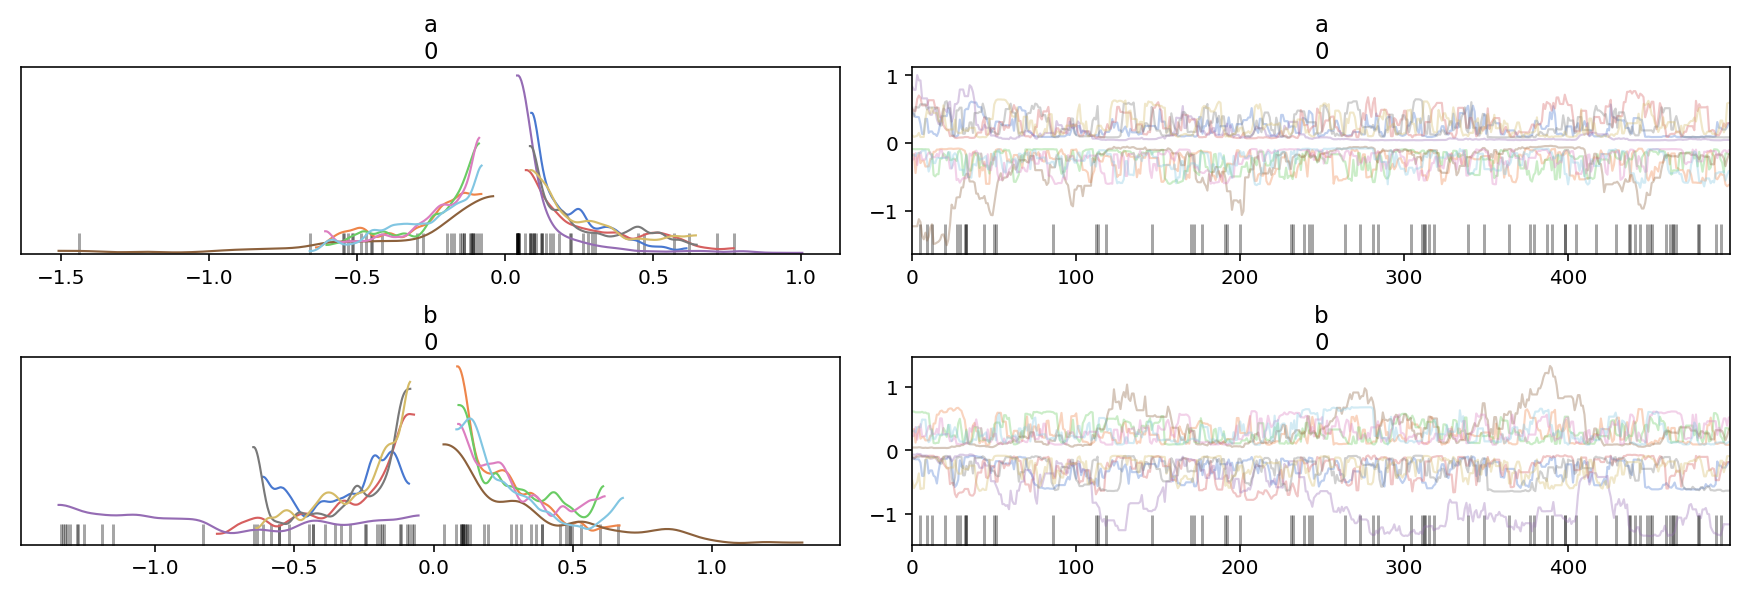

In [0]:
az.plot_trace(trace1);

# Model Dos